In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, Input
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
from utils import get_manipulated_images, get_wb_images

In [3]:
ANA_DIZIN = r"C:\Users\Volkan Nalca\Desktop\Siniflandirma\Animals_with_Attributes2\JPEGImages"
SECILEN_SINIFLAR = ["collie", "dolphin", "elephant", "fox", "moose", "rabbit", "sheep", "squirrel", "giant+panda", "polar+bear"]
RESIM_BOYUTU = (128, 128)

In [5]:
def resmi_yeniden_boyutlandir_ve_normallestir(resim_yolu, boyut):
    try:
        img = cv2.imread(resim_yolu)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_resized = cv2.resize(img, boyut)
        img_normalized = img_resized / 255.0
        return img_normalized
    except Exception as e:
        print(f"Hata: {resim_yolu} işlenirken bir hata oluştu: {e}")
        return None

In [7]:
veri = {'resim': [], 'etiket': []}

for kok_dizin, alt_dizinler, dosyalar in os.walk(ANA_DIZIN):
    sinif_adi = os.path.basename(kok_dizin)
    if sinif_adi in SECILEN_SINIFLAR:
        print(f"{sinif_adi} sınıfı işleniyor...")
        dosya_sayisi = 0
        for dosya in dosyalar:
            if dosya_sayisi >= 650:
                break
            if dosya.lower().endswith(('.jpg', '.jpeg', '.png')):
                dosya_yolu = os.path.join(kok_dizin, dosya)
                img_normalized = resmi_yeniden_boyutlandir_ve_normallestir(dosya_yolu, RESIM_BOYUTU)
                if img_normalized is not None:
                    veri['resim'].append(img_normalized)
                    veri['etiket'].append(sinif_adi)
                    dosya_sayisi += 1

veri_cercevesi = pd.DataFrame(veri)

collie sınıfı işleniyor...
dolphin sınıfı işleniyor...
elephant sınıfı işleniyor...
fox sınıfı işleniyor...
giant+panda sınıfı işleniyor...
moose sınıfı işleniyor...
polar+bear sınıfı işleniyor...
rabbit sınıfı işleniyor...
sheep sınıfı işleniyor...
squirrel sınıfı işleniyor...


In [9]:
print(veri_cercevesi.head())
print(veri_cercevesi['etiket'].value_counts())

                                               resim  etiket
0  [[[0.47058823529411764, 0.25098039215686274, 0...  collie
1  [[[0.25098039215686274, 0.2549019607843137, 0....  collie
2  [[[0.043137254901960784, 0.0784313725490196, 0...  collie
3  [[[0.21568627450980393, 0.41568627450980394, 0...  collie
4  [[[0.18823529411764706, 0.19607843137254902, 0...  collie
etiket
collie         650
dolphin        650
elephant       650
fox            650
giant+panda    650
moose          650
polar+bear     650
rabbit         650
sheep          650
squirrel       650
Name: count, dtype: int64


In [11]:
X = np.array(veri_cercevesi['resim'].tolist())
y = np.array(veri_cercevesi['etiket'].tolist())

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)
y_one_hot = to_categorical(y_encoded)

X_train, X_test, y_train, y_test = train_test_split(X, y_one_hot, test_size=0.3, random_state=42, stratify=y_one_hot)

In [13]:
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

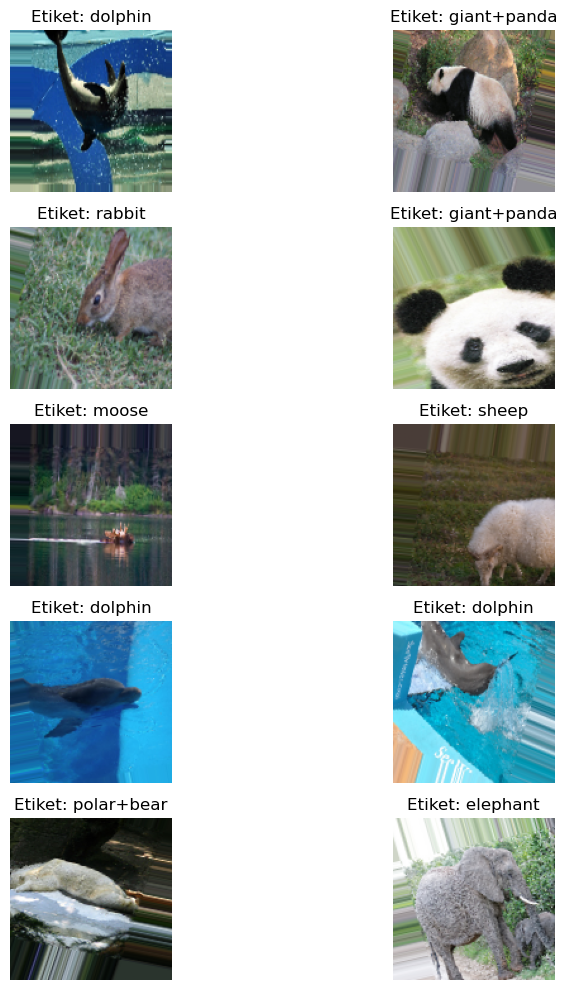

In [14]:
plt.figure(figsize=(10, 10))
for X_batch, y_batch in datagen.flow(X_train, y_train, batch_size=10):
    for i in range(0, 10):
        plt.subplot(5, 2, 1 + i)
        plt.imshow(X_batch[i])
        plt.title(f"Etiket: {label_encoder.inverse_transform(y_batch[i].argmax(axis=0).reshape(1))[0]}")
        plt.axis('off')
    plt.tight_layout()
    plt.show()
    break

In [15]:
model = Sequential()

model.add(Input(shape=X_train.shape[1:]))

model.add(Conv2D(32, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(10))
model.add(Activation('softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64, 64, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 64, 64, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32, 32, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 32, 32, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 16, 16, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 32768)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    16,777,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         5,130 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_4 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 16,876,106 (64.38 MB)

 Trainable params: 16,876,106 (64.38 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                    validation_data=(X_test, y_test),
                    epochs=25,
                    steps_per_epoch=(len(X_train) * 2) // 32)

model.save('hayvan_siniflandirma_modeli.keras')

C:\Anaconda\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/25
143/284 ━━━━━━━━━━━━━━━━━━━━ 1:39 708ms/step - accuracy: 0.1580 - loss: 2.4087

C:\Anaconda\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


284/284 ━━━━━━━━━━━━━━━━━━━━ 128s 434ms/step - accuracy: 0.1777 - loss: 2.2858 - val_accuracy: 0.3241 - val_loss: 1.9375
Epoch 2/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 102s 354ms/step - accuracy: 0.3227 - loss: 1.8797 - val_accuracy: 0.4031 - val_loss: 1.6775
Epoch 3/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 142s 498ms/step - accuracy: 0.3740 - loss: 1.7317 - val_accuracy: 0.4585 - val_loss: 1.5932
Epoch 4/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 120s 416ms/step - accuracy: 0.4199 - loss: 1.6443 - val_accuracy: 0.5092 - val_loss: 1.4534
Epoch 5/25
284/284 ━━━━━━━━━━━━━━━━━━━━ 109s 382ms/step - accuracy: 0.4499 - loss: 1.5453 - val_accuracy: 0.5528 - val_loss: 1.3475
Epoch 6/25
117/284 ━━━━━━━━━━━━━━━━━━━━ 2:01 730ms/step - accuracy: 0.4719 - loss: 1.4761

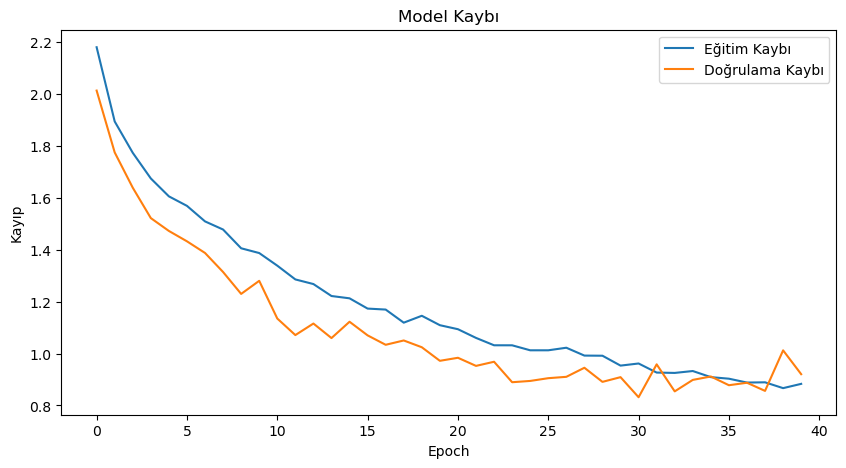

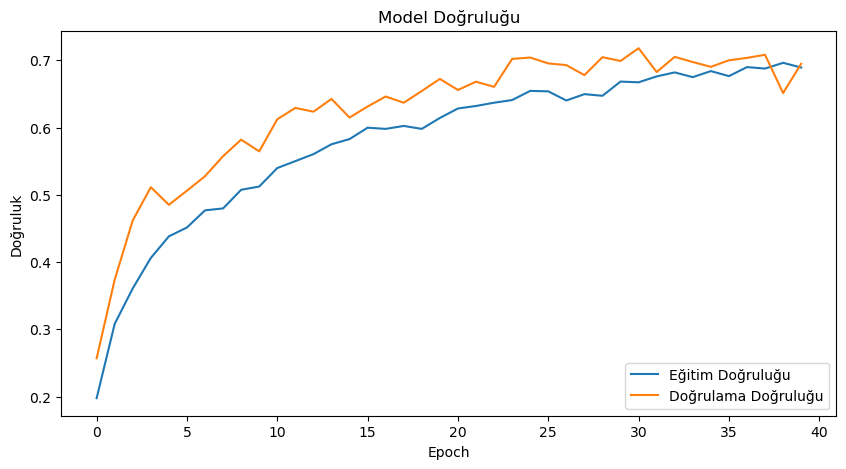

In [21]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.ylabel('Kayıp')
plt.xlabel('Epoch')
plt.legend(loc='upper right')
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.ylabel('Doğruluk')
plt.xlabel('Epoch')
plt.legend(loc='lower right')
plt.show()

Test Kaybı (Test Loss): 0.9204
Test Doğruluğu (Test Accuracy): 0.6949
61/61 ━━━━━━━━━━━━━━━━━━━━ 9s 128ms/step
              precision    recall  f1-score   support

      collie       0.75      0.36      0.49       195
     dolphin       0.95      0.82      0.88       195
    elephant       0.58      0.89      0.70       195
         fox       0.67      0.55      0.61       195
 giant+panda       0.89      0.96      0.92       195
       moose       0.51      0.77      0.62       195
  polar+bear       0.83      0.81      0.82       195
      rabbit       0.59      0.67      0.63       195
       sheep       0.69      0.71      0.70       195
    squirrel       0.69      0.42      0.52       195

    accuracy                           0.69      1950
   macro avg       0.72      0.69      0.69      1950
weighted avg       0.72      0.69      0.69      1950



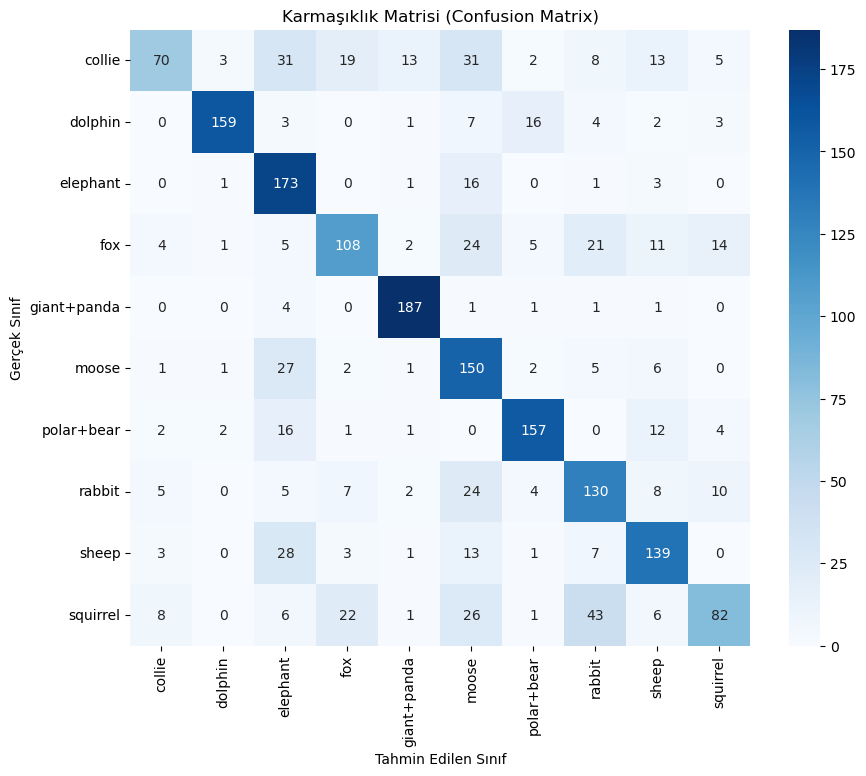

In [23]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

loss, accuracy = model.evaluate(X_test, y_test, verbose=0)

print(f"Test Kaybı (Test Loss): {loss:.4f}")
print(f"Test Doğruluğu (Test Accuracy): {accuracy:.4f}")

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

print(classification_report(y_true, y_pred_classes, target_names=label_encoder.classes_))

cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Karmaşıklık Matrisi (Confusion Matrix)")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()

In [25]:
manipulated_images_dir = "manipulated_test_images"

if not os.path.exists(manipulated_images_dir):
    os.makedirs(manipulated_images_dir)

X_test_manipulated = []
y_test_manipulated = []

for i in range(len(X_test)):
    img = (X_test[i] * 255).astype(np.uint8)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    img_save_folder = os.path.join(manipulated_images_dir, str(i))

    if not os.path.exists(img_save_folder):
        os.makedirs(img_save_folder)

    manipulated_images = get_manipulated_images(img, img_save_folder)

    # Sadece gamma ve hist_eq kullan (BGR'yi RGB'ye çevir)
    X_test_manipulated.append(cv2.cvtColor(manipulated_images["gamma_0.5"], cv2.COLOR_BGR2RGB))
    X_test_manipulated.append(cv2.cvtColor(manipulated_images["gamma_1.5"], cv2.COLOR_BGR2RGB))
    X_test_manipulated.append(cv2.cvtColor(manipulated_images["hist_eq"], cv2.COLOR_BGR2RGB))

    y_test_manipulated.append(y_test[i])
    y_test_manipulated.append(y_test[i])
    y_test_manipulated.append(y_test[i])

X_test_manipulated = np.array(X_test_manipulated) / 255.0
y_test_manipulated = np.array(y_test_manipulated)

Manipüle Edilmiş Test Kaybı: 1.8102
Manipüle Edilmiş Test Doğruluğu: 0.4395
122/122 ━━━━━━━━━━━━━━━━━━━━ 14s 108ms/step
              precision    recall  f1-score   support

      collie       0.45      0.19      0.27       390
     dolphin       0.92      0.64      0.75       390
    elephant       0.44      0.49      0.47       390
         fox       0.56      0.20      0.29       390
 giant+panda       0.92      0.37      0.53       390
       moose       0.38      0.33      0.36       390
  polar+bear       0.33      0.82      0.47       390
      rabbit       0.40      0.47      0.43       390
       sheep       0.55      0.34      0.42       390
    squirrel       0.29      0.54      0.37       390

    accuracy                           0.44      3900
   macro avg       0.52      0.44      0.44      3900
weighted avg       0.52      0.44      0.44      3900



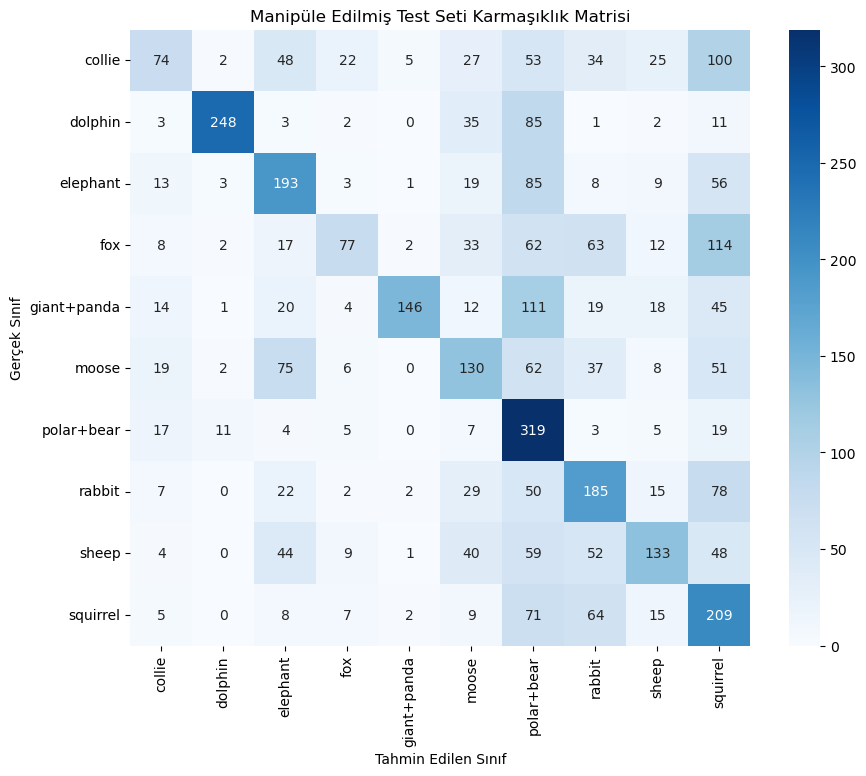

In [27]:
loss_manipulated, accuracy_manipulated = model.evaluate(X_test_manipulated, y_test_manipulated, verbose=0)

print(f"Manipüle Edilmiş Test Kaybı: {loss_manipulated:.4f}")
print(f"Manipüle Edilmiş Test Doğruluğu: {accuracy_manipulated:.4f}")

y_pred_manipulated = model.predict(X_test_manipulated)
y_pred_classes_manipulated = np.argmax(y_pred_manipulated, axis=1)
y_true_manipulated = np.argmax(y_test_manipulated, axis=1)

print(classification_report(y_true_manipulated, y_pred_classes_manipulated, target_names=label_encoder.classes_))

cm_manipulated = confusion_matrix(y_true_manipulated, y_pred_classes_manipulated)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_manipulated, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Manipüle Edilmiş Test Seti Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()

In [29]:
wb_images_dir = "wb_test_images"

if not os.path.exists(wb_images_dir):
    os.makedirs(wb_images_dir)

X_test_wb = []

for i in range(len(X_test_manipulated)):
    img_bgr = (X_test_manipulated[i] * 255).astype(np.uint8)
    img_bgr = cv2.cvtColor(img_bgr, cv2.COLOR_RGB2BGR) # RGB -> BGR
    wb_img = get_wb_images(img_bgr)
    wb_img_rgb = cv2.cvtColor(wb_img, cv2.COLOR_BGR2RGB) # BGR -> RGB
    X_test_wb.append(wb_img_rgb)
    cv2.imwrite(os.path.join(wb_images_dir, f"wb_image_{i}.jpg"), wb_img)

X_test_wb = np.array(X_test_wb) / 255.0

Renk Sabitliği Uygulanmış Test Kaybı: 2.0211
Renk Sabitliği Uygulanmış Test Doğruluğu: 0.3536
122/122 ━━━━━━━━━━━━━━━━━━━━ 15s 122ms/step
              precision    recall  f1-score   support

      collie       0.30      0.21      0.24       390
     dolphin       0.73      0.17      0.28       390
    elephant       0.43      0.39      0.41       390
         fox       0.37      0.16      0.23       390
 giant+panda       0.91      0.38      0.54       390
       moose       0.31      0.30      0.30       390
  polar+bear       0.31      0.79      0.45       390
      rabbit       0.39      0.34      0.36       390
       sheep       0.62      0.22      0.32       390
    squirrel       0.22      0.58      0.32       390

    accuracy                           0.35      3900
   macro avg       0.46      0.35      0.35      3900
weighted avg       0.46      0.35      0.35      3900



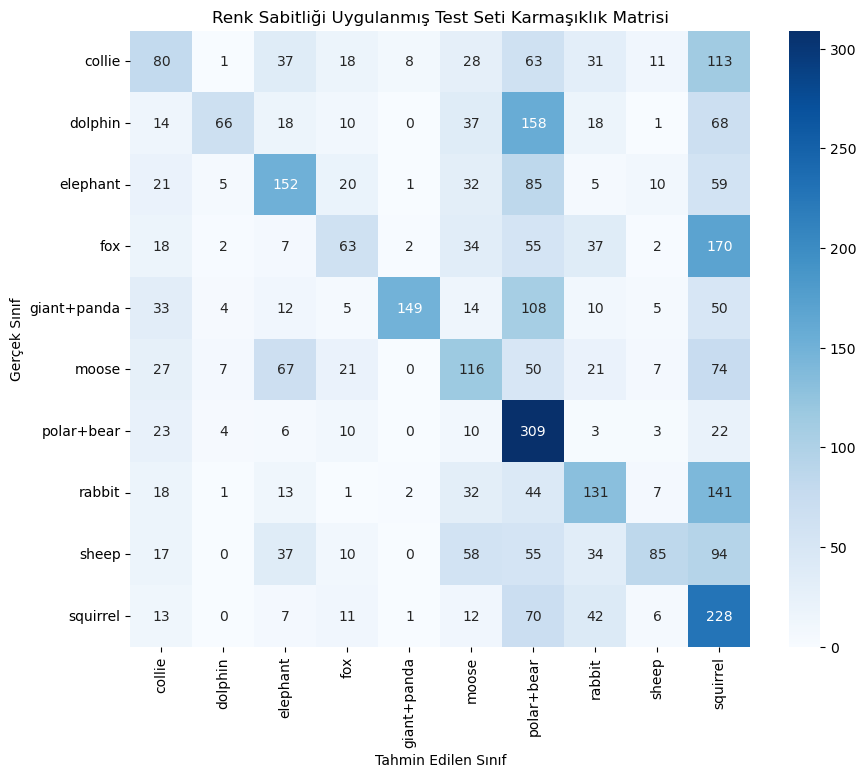

In [31]:
loss_wb, accuracy_wb = model.evaluate(X_test_wb, y_test_manipulated, verbose=0)

print(f"Renk Sabitliği Uygulanmış Test Kaybı: {loss_wb:.4f}")
print(f"Renk Sabitliği Uygulanmış Test Doğruluğu: {accuracy_wb:.4f}")

y_pred_wb = model.predict(X_test_wb)
y_pred_classes_wb = np.argmax(y_pred_wb, axis=1)
y_true_wb = np.argmax(y_test_manipulated, axis=1)

print(classification_report(y_true_wb, y_pred_classes_wb, target_names=label_encoder.classes_))

cm_wb = confusion_matrix(y_true_wb, y_pred_classes_wb)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_wb, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Renk Sabitliği Uygulanmış Test Seti Karmaşıklık Matrisi")
plt.xlabel("Tahmin Edilen Sınıf")
plt.ylabel("Gerçek Sınıf")
plt.show()

                   Test Seti  Kayıp (Loss)  Doğruluk (Accuracy)
0                   Orijinal      0.920447             0.694872
1           Manipüle Edilmiş      1.810208             0.439487
2  Renk Sabitliği Uygulanmış      2.021084             0.353590

RAPOR:
- Model, orijinal test setinde en yüksek doğruluğu elde etti: %69.49
- Işık manipülasyonları, modelin doğruluğunu %25.54 düşürdü ( %43.95 ).
- Renk sabitliği algoritması (Gray World), modelin doğruluğunu %-8.59 iyileştirdi ( %35.36 ).


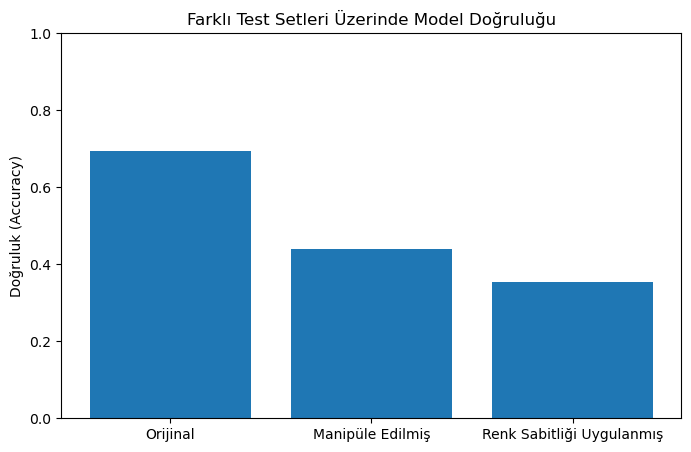


Renk sabitliği uygulanmış test setindeki başarım hala düşük. Olası çözüm yolları:
- Daha gelişmiş renk sabitliği algoritmaları kullanmak.
- Eğitim verilerine farklı ışık koşullarında ve renk düzeltmesi uygulanmış resimler eklemek (veri çoğaltma).
- Modeli daha fazla veriyle veya daha uzun süre eğitmek.
- Model mimarisini değiştirmek.
- Transfer öğrenmesi (transfer learning) kullanmak.
- Hata analizi yapmak: Modelin hangi sınıfları karıştırdığını ve hangi tür resimlerde hata yaptığını incelemek.


In [35]:
results = pd.DataFrame({
    "Test Seti": ["Orijinal", "Manipüle Edilmiş", "Renk Sabitliği Uygulanmış"],
    "Kayıp (Loss)": [loss, loss_manipulated, loss_wb],
    "Doğruluk (Accuracy)": [accuracy, accuracy_manipulated, accuracy_wb]
})

print(results)

print("\nRAPOR:")
print(f"- Model, orijinal test setinde en yüksek doğruluğu elde etti: %{results['Doğruluk (Accuracy)'][0]*100:.2f}")
print(f"- Işık manipülasyonları, modelin doğruluğunu %{results['Doğruluk (Accuracy)'][0]*100 - results['Doğruluk (Accuracy)'][1]*100:.2f} düşürdü ( %{results['Doğruluk (Accuracy)'][1]*100:.2f} ).")
print(f"- Renk sabitliği algoritması (Gray World), modelin doğruluğunu %{results['Doğruluk (Accuracy)'][2]*100 - results['Doğruluk (Accuracy)'][1]*100:.2f} iyileştirdi ( %{results['Doğruluk (Accuracy)'][2]*100:.2f} ).")

plt.figure(figsize=(8, 5))
plt.bar(results["Test Seti"], results["Doğruluk (Accuracy)"])
plt.title("Farklı Test Setleri Üzerinde Model Doğruluğu")
plt.ylabel("Doğruluk (Accuracy)")
plt.ylim([0, 1])
plt.show()

if accuracy_wb < 0.6:
    print("\nRenk sabitliği uygulanmış test setindeki başarım hala düşük. Olası çözüm yolları:")
    print("- Daha gelişmiş renk sabitliği algoritmaları kullanmak.")
    print("- Eğitim verilerine farklı ışık koşullarında ve renk düzeltmesi uygulanmış resimler eklemek (veri çoğaltma).")
    print("- Modeli daha fazla veriyle veya daha uzun süre eğitmek.")
    print("- Model mimarisini değiştirmek.")
    print("- Transfer öğrenmesi (transfer learning) kullanmak.")
    print("- Hata analizi yapmak: Modelin hangi sınıfları karıştırdığını ve hangi tür resimlerde hata yaptığını incelemek.")
else:
    print("\nRenk sabitliği uygulanmış test seti üzerindeki başarım kabul edilebilir düzeyde.")